In [1]:
# Coding the optimal budget distribution model using Pyomo -> Last Touch Optimization

#Import the libraries

import numpy as np
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po
import matplotlib.pyplot as plt

from pyomo.environ import *

In [4]:
# Testing configuration file
import sys

config_file_url = '../../01_data/configuration_file_general_v2.xlsx'

# Read the products and media platforms data from the configuration file
product_media_raw_data = pd.read_excel(config_file_url, sheet_name ='Mix')
product_media_raw_data.head(15)

,Producto,Medio,Tasa_Conversiones,Tasa_Leads,Tasa_Clicks,CPL,CPA,Clase
0,efi,DV360,0.000367,0.0,0.039258,0.0,5155.960208,Conversiones
1,efi,Facebook,0.014512,0.0,0.310307,0.0,180.407941,Conversiones
2,efi,Google Display Network,0.000000,0.0,0.464107,0.0,0.000000,Conversiones
3,efi,Google Search Ads,0.002461,0.0,0.182924,0.0,3338.241350,Conversiones
4,efi,Medios Terceros,0.000000,0.0,0.000000,0.0,0.000000,Conversiones
5,efi,Performance Max,0.000000,0.0,0.000000,0.0,0.000000,Conversiones
6,efi,Zoom D,0.000000,0.0,0.000000,0.0,0.000000,Conversiones
7,efi,Amazon,0.000000,0.0,0.000000,0.0,0.000000,Conversiones
8,efi,Rocket,0.000000,0.0,0.000000,0.0,0.000000,Conversiones
9,efi,TikTok,0.000000,0.0,0.000000,0.0,0.000000,Conversiones


In [5]:
# Read the products data from the configuration file
product_raw_data = pd.read_excel(config_file_url, sheet_name = 'Productos')
product_raw_data.head(10)

,ID,peso_min,presupuesto,Riesgo,Resultado,Clase
0,adelanto_sueldo,0,5242.167045,0,14.311275,Conversiones
1,apartados,0,15739.932800,0,0.000000,Sin trazabilidad
2,app_bbva,0,63159.168789,0,4089.651250,Installs
3,app_bbva_vinculacion,0,5881.021200,0,343.500000,Installs
4,app_plan,0,5717.473000,0,0.000000,Installs
5,asd_auto,0,219342.803540,0,73.359659,Conversiones
6,asd_moto,0,117652.288594,0,34.033460,Conversiones
7,banca_barrio,0,16718.096228,0,0.000000,Sin trazabilidad
8,banca_barriocodi,0,241.521000,0,0.000000,Sin trazabilidad
9,banca_barriorestaur,0,4454.673750,0,0.000000,Sin trazabilidad


In [6]:
# Read the media platforms data from the configuration file
media_raw_data = pd.read_excel(config_file_url, sheet_name = 'Medios')
media_raw_data.head(10)

,ID,Inversion_min,Inversion_max
0,Amazon,1000,4000000
1,DV360,1000,4000000
2,Facebook,1000,4000000
3,Google Display Network,1000,4000000
4,Google Search Ads,1000,4000000
5,Medios Terceros,1000,4000000
6,Performance Max,1000,4000000
7,Rocket,1000,4000000
8,TikTok,1000,4000000
9,Zoom D,1000,4000000


In [17]:
# Read historic data
historic_raw_data = pd.read_excel(config_file_url, sheet_name = 'Historic')
historic_raw_data.head(10)

,Fecha,Producto,Medio,Inversion,Impresiones,Clicks,Conversiones,Leads,Resultado,Clicks/Impresiones,Conv/Impresiones,Leads/Impresiones,CPI,CPL,CPA,Leads/Impresiones\t
0,2021-01-01,efi,DV360,62084.5,738792,1178,0.0,0,0.0,0.001594,0.000000,0.0,11.899782,0.0,0.000000,0.0
1,2021-02-01,efi,DV360,3996.8,17014,14,0.0,0,0.0,0.000823,0.000000,0.0,4.256906,0.0,0.000000,0.0
2,2021-03-01,efi,DV360,6469.6,94141,105,0.0,0,0.0,0.001115,0.000000,0.0,14.551286,0.0,0.000000,0.0
3,2021-04-01,efi,DV360,6486.4,149928,168,0.0,0,0.0,0.001121,0.000000,0.0,23.114208,0.0,0.000000,0.0
4,2021-05-01,efi,DV360,8001.1,124195,125,1.0,0,1.0,0.001006,0.000008,0.0,15.522241,0.0,8001.100000,0.0
5,2021-06-01,efi,DV360,9488.8,119466,102,4.0,0,4.0,0.000854,0.000033,0.0,12.590212,0.0,2372.200000,0.0
6,2021-07-01,efi,DV360,0.0,0,0,5.0,0,5.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
7,2021-08-01,efi,DV360,9979.4,313356,166,1.0,0,1.0,0.000530,0.000003,0.0,31.400285,0.0,9979.400000,0.0
8,2021-09-01,efi,DV360,9973.4,411495,238,8.0,0,8.0,0.000578,0.000019,0.0,41.259250,0.0,1246.675000,0.0
9,2021-10-01,efi,DV360,9956.8,324417,141,3.0,0,3.0,0.000435,0.000009,0.0,32.582456,0.0,3318.933333,0.0


In [18]:
historic_raw_data.shape

(25550, 16)

In [19]:
columns_to_delete = ["Inversion", "Impresiones", "Clicks", "Conversiones", "Leads", "Clicks/Impresiones", "Conv/Impresiones",
                     "Leads/Impresiones", "CPI", "CPL", "CPA"]

# Deleting the specified columns
historic_raw_data_deleted = historic_raw_data
historic_raw_data_deleted.drop(columns=columns_to_delete, inplace=True)

print(historic_raw_data_deleted.head())

        Fecha Producto  Medio  Resultado  Leads/Impresiones\t
0  2021-01-01      efi  DV360        0.0                  0.0
1  2021-02-01      efi  DV360        0.0                  0.0
2  2021-03-01      efi  DV360        0.0                  0.0
3  2021-04-01      efi  DV360        0.0                  0.0
4  2021-05-01      efi  DV360        1.0                  0.0


In [21]:
# List of products to filter
productos_filtrados = "double_play", "credito_nomina", "credito_pyme", "credito_auto", "credito_hipotecario"

# Filtering the DataFrame based on selected products
filtered_df = historic_raw_data_deleted[historic_raw_data_deleted["Producto"].isin(productos_filtrados)]

# Calculating the sum of conversions for filtered products
sum_conversions_df = filtered_df.groupby(["Fecha", "Producto"])["Resultado"].sum().reset_index()
sum_conversions_df.rename(columns={"Resultado": "Sum_resultado"}, inplace=True)

# Displaying the new DataFrame
sum_conversions_df.head(10)

,Fecha,Producto,Sum_resultado
0,2021-01-01,credito_auto,105.0
1,2021-01-01,credito_hipotecario,295.0
2,2021-01-01,credito_nomina,0.0
3,2021-01-01,credito_pyme,22.0
4,2021-01-01,double_play,0.0
5,2021-02-01,credito_auto,159.0
6,2021-02-01,credito_hipotecario,593.0
7,2021-02-01,credito_nomina,169.0
8,2021-02-01,credito_pyme,16.0
9,2021-02-01,double_play,0.0


In [14]:
# Pivot the DataFrame to have Product as columns and Date as index
pivot_table = sum_conversions_df.pivot(index="Fecha", columns="Producto", values="Sum_resultado")

# Calculate the covariances
covariance_matrix = pivot_table.cov()

# Get the list of unique products
products = sum_conversions_df["Producto"].unique()

# Calculate and print the covariances for all combinations of products
for i in range(len(products)):
    for j in range(i, len(products)):
        product1 = products[i]
        product2 = products[j]
        covariance_prod = covariance_matrix.loc[product1, product2]
        print(f"Covariance ({product1}, {product2}): {covariance_prod}")

Covariance (credito_auto, credito_auto): 9626.593277310925
Covariance (credito_auto, credito_hipotecario): 17240.031092436973
Covariance (credito_auto, credito_nomina): 1918.7718487394964
Covariance (credito_auto, credito_pyme): 1294.1638655462186
Covariance (credito_auto, double_play): -116949.55042016805
Covariance (credito_hipotecario, credito_hipotecario): 202291.6084033613
Covariance (credito_hipotecario, credito_nomina): 16808.35042016806
Covariance (credito_hipotecario, credito_pyme): -20.298319327731303
Covariance (credito_hipotecario, double_play): 203411.2184873949
Covariance (credito_nomina, credito_nomina): 64354.30546218487
Covariance (credito_nomina, credito_pyme): -4771.539915966387
Covariance (credito_nomina, double_play): 812743.6638655465
Covariance (credito_pyme, credito_pyme): 3079.3109243697477
Covariance (credito_pyme, double_play): -141738.52100840336
Covariance (double_play, double_play): 21855456.68067227


In [15]:
# Pivot the DataFrame to have Product as columns and Date as index
pivot_table = sum_conversions_df.pivot(index="Fecha", columns="Producto", values="Sum_resultado")

# Calculate the correlations
correlation_matrix = pivot_table.corr()

# Get the list of unique products
products = sum_conversions_df["Producto"].unique()

# Calculate and print the covariances for all combinations of products
for i in range(len(products)):
    for j in range(i, len(products)):
        product1 = products[i]
        product2 = products[j]
        correlations_prod = correlation_matrix.loc[product1, product2]
        print(f"Covariance ({product1}, {product2}): {correlations_prod}")

Covariance (credito_auto, credito_auto): 1.0
Covariance (credito_auto, credito_hipotecario): 0.3906724619303095
Covariance (credito_auto, credito_nomina): 0.07709003141405738
Covariance (credito_auto, credito_pyme): 0.23769836073750042
Covariance (credito_auto, double_play): -0.2549660184766165
Covariance (credito_hipotecario, credito_hipotecario): 1.0
Covariance (credito_hipotecario, credito_nomina): 0.14731513094659718
Covariance (credito_hipotecario, credito_pyme): -0.0008132880205542664
Covariance (credito_hipotecario, double_play): 0.09673998701731694
Covariance (credito_nomina, credito_nomina): 1.0
Covariance (credito_nomina, credito_pyme): -0.3389557347485202
Covariance (credito_nomina, double_play): 0.6853064916990901
Covariance (credito_pyme, credito_pyme): 1.0
Covariance (credito_pyme, double_play): -0.5463628760891867
Covariance (double_play, double_play): 1.0


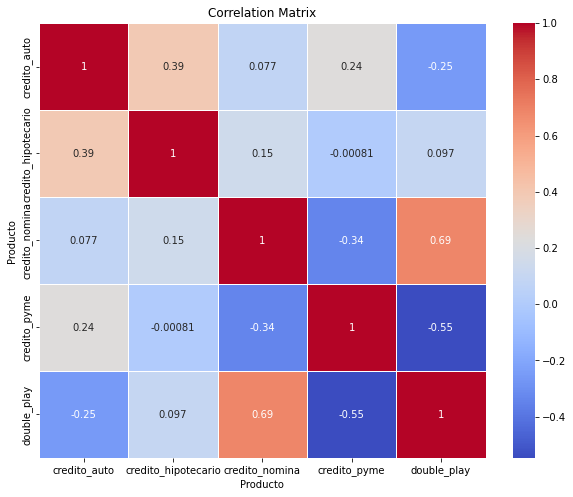

In [16]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the preferred products and media
filtered_df = historic_raw_data_deleted[historic_raw_data_deleted["Producto"].isin(productos_filtrados)]

sum_conversions_df = filtered_df.groupby(["Fecha", "Producto"])["Resultado"].sum().reset_index()
sum_conversions_df.rename(columns={"Resultado": "Sum_resultado"}, inplace=True)

# Pivot the DataFrame to have media platforms as separate columns
pivot_table = sum_conversions_df.pivot(index="Fecha", columns="Producto", values="Sum_resultado")

# Calculate the correlations
correlation_matrix = pivot_table.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [22]:
# Filter media platforms
medios_filtrados = ["Amazon", "DV360", "Facebook", "Google Display Network", "Google Search Ads", "Medios Terceros", "Performance Max", "Rocket", "TikTok", "Zoom D"]

In [23]:
# Filter the DataFrame for the preferred products and media platforms
filtered_df = historic_raw_data[(historic_raw_data["Producto"].isin(productos_filtrados)) & (historic_raw_data["Medio"].isin(medios_filtrados))]

# Pivot the DataFrame to have media platforms as separate columns
pivot_df = filtered_df.pivot(index=["Producto", "Fecha"], columns="Medio", values="Resultado").reset_index()

# Get unique products
unique_products = pivot_df["Producto"].unique()

# Calculate covariances for all combinations of media within each product
for product in unique_products:
    product_df = pivot_df[pivot_df["Producto"] == product]
    media_covariances = []

    for media1 in medios_filtrados:
        for media2 in medios_filtrados:
            covariance = product_df[media1].cov(product_df[media2])
            media_covariances.append((media1, media2, covariance))

    print(f"Producto: {product}")
    for media1, media2, covariance in media_covariances:
        print(f"covariance ({media1}, {media2}): {covariance}")
    print("\n")

Producto: double_play
covariance (Amazon, Amazon): 20.3409090909091
covariance (Amazon, DV360): 166.93181818181822
covariance (Amazon, Facebook): -852.463068181818
covariance (Amazon, Google Display Network): -2053.0454545454545
covariance (Amazon, Google Search Ads): -201.26136363636368
covariance (Amazon, Medios Terceros): 3657.451704545454
covariance (Amazon, Performance Max): 463.7556818181816
covariance (Amazon, Rocket): -0.35227272727272724
covariance (Amazon, TikTok): -61.73579545454545
covariance (Amazon, Zoom D): 0.0
covariance (DV360, Amazon): 166.93181818181822
covariance (DV360, DV360): 2339.8636363636365
covariance (DV360, Facebook): 6977.855113636363
covariance (DV360, Google Display Network): -4775.590909090907
covariance (DV360, Google Search Ads): 26876.977272727283
covariance (DV360, Medios Terceros): 42191.434659090926
covariance (DV360, Performance Max): 22338.073863636368
covariance (DV360, Rocket): -0.14204545454545495
covariance (DV360, TikTok): -119.940340909090

In [24]:
# Filter the DataFrame for the preferred products and media
filtered_df = historic_raw_data[(historic_raw_data["Producto"].isin(productos_filtrados)) & (historic_raw_data["Medio"].isin(medios_filtrados))]

# Pivot the DataFrame to have media platforms as separate columns
pivot_df = filtered_df.pivot(index=["Producto", "Fecha"], columns="Medio", values="Resultado").reset_index()

# Get unique products
unique_products = pivot_df["Producto"].unique()

# Calculate covariances for all combinations of media within each product
for product in unique_products:
    product_df = pivot_df[pivot_df["Producto"] == product]
    media_correlations = []

    for media1 in medios_filtrados:
        for media2 in medios_filtrados:
            correlation = product_df[media1].corr(product_df[media2])
            media_correlations.append((media1, media2, correlation))

    print(f"Producto: {product}")
    for media1, media2, correlation in media_correlations:
        print(f"correlation ({media1}, {media2}): {correlation}")
    print("\n")

Producto: double_play
correlation (Amazon, Amazon): 0.9999999999999998
correlation (Amazon, DV360): 0.7651712964552507
correlation (Amazon, Facebook): -0.1650974613960871
correlation (Amazon, Google Display Network): -0.37893042945631605
correlation (Amazon, Google Search Ads): -0.02336449759957823
correlation (Amazon, Medios Terceros): 0.7930225401762583
correlation (Amazon, Performance Max): 0.11785329140235855
correlation (Amazon, Rocket): -0.14323890004414158
correlation (Amazon, TikTok): -0.18520113605034202
correlation (Amazon, Zoom D): nan
correlation (DV360, Amazon): 0.7651712964552507
correlation (DV360, DV360): 1.0
correlation (DV360, Facebook): 0.12600177861120387
correlation (DV360, Google Display Network): -0.08218223337452289
correlation (DV360, Google Search Ads): 0.2909151679852849
correlation (DV360, Medios Terceros): 0.8529452007756612
correlation (DV360, Performance Max): 0.5292831892953637
correlation (DV360, Rocket): -0.0053851673230852805
correlation (DV360, TikTo

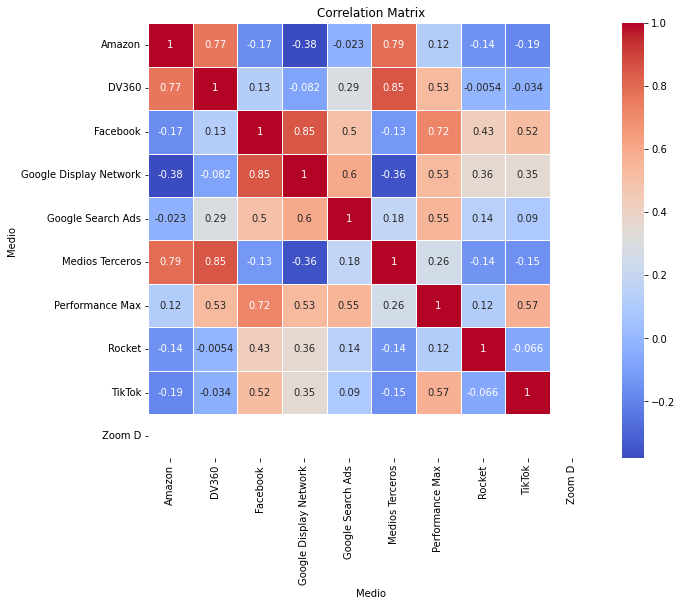

In [25]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the preferred products and media
filtered_df = historic_raw_data[(historic_raw_data["Producto"].isin(productos_filtrados)) & (historic_raw_data["Medio"].isin(medios_filtrados))]

# Pivot the DataFrame to have media platforms as separate columns
pivot_df = filtered_df.pivot(index=["Producto", "Fecha"], columns="Medio", values="Resultado").reset_index()

# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [26]:
product_media_raw_data = product_media_raw_data[(product_media_raw_data['Producto'].isin(productos_filtrados)) 
                                                    & (product_media_raw_data['Medio'].isin(medios_filtrados))]
product_media_raw_data.head(19)

,Producto,Medio,Tasa_Conversiones,Tasa_Leads,Tasa_Clicks,CPL,CPA,Clase
290,double_play,DV360,0.000057,0.000966,0.559163,1412.799152,36836.478720,Conversiones
291,double_play,Facebook,0.000162,0.003728,0.161114,402.021199,6874.265498,Conversiones
292,double_play,Google Display Network,0.000220,0.005755,0.164981,213.198576,5617.350037,Conversiones
293,double_play,Google Search Ads,0.001685,0.011771,0.119305,283.685016,969.348175,Conversiones
294,double_play,Medios Terceros,0.002290,0.090000,0.000000,12.567977,408.006659,Conversiones
295,double_play,Performance Max,0.000333,0.004670,0.511994,455.743552,6458.437897,Conversiones
296,double_play,Zoom D,0.000000,0.000000,0.000000,0.000000,0.000000,Conversiones
297,double_play,Amazon,0.000039,0.000359,0.130358,4293.917852,54811.764670,Conversiones
298,double_play,Rocket,0.000000,0.000000,0.000000,0.000000,0.000000,Conversiones
299,double_play,TikTok,0.000286,0.010286,0.218584,232.508548,9636.197643,Conversiones


In [27]:
product_raw_data = product_raw_data[product_raw_data['ID'].isin(productos_filtrados)]
# product_raw_data = product_raw_data[product_raw_data['ID'].isin(selected_products)] # Cambia según el objetivo
product_raw_data.head(5)

,ID,peso_min,presupuesto,Riesgo,Resultado,Clase
75,double_play,0,3.401082e+07,100000,657.67301,Conversiones


In [28]:
media_raw_data = media_raw_data[media_raw_data['ID'].isin(medios_filtrados)]
media_raw_data.head(10)

,ID,Inversion_min,Inversion_max
0,DV360,5.165140e+05,1.072760e+06
1,Facebook,6.144810e+06,1.276230e+07
2,Google Display Network,9.439579e+06,1.960528e+07
3,Google Search Ads,8.722202e+05,1.811534e+06
4,Medios Terceros,7.402200e+04,1.537380e+05
5,Performance Max,4.928824e+06,1.023679e+07
6,Zoom D,0.000000e+00,0.000000e+00
7,Amazon,0.000000e+00,0.000000e+00
8,Rocket,0.000000e+00,0.000000e+00
9,TikTok,4.610279e+05,9.575195e+05


In [29]:
# Optimization model

product_media_data = product_media_raw_data
product_data = product_raw_data
media_data = media_raw_data

# Subset
conversion_products = set(product_data[product_data["Clase"] == "Conversiones"]["ID"].drop_duplicates())
lead_products = set(product_data[product_data["Clase"] == "Leads"]["ID"].drop_duplicates())

# Sets
model = pe.ConcreteModel('presupuesto')
model.products = pe.Set(initialize = product_data['ID'].drop_duplicates())
model.conversion_products = pe.Set(within=model.products, initialize=conversion_products)
model.lead_products = pe.Set(within=model.products, initialize=lead_products)
model.media = pe.Set(initialize = media_data['ID'].drop_duplicates())

product_data = product_data.set_index('ID')
media_data = media_data.set_index('ID')
product_media_data = product_media_data.set_index(['Producto','Medio'])

print("The number of elements in the set {model.conversion_products} is: ", len(model.conversion_products))
print("The number of elements in the set {model.lead_products} is: ", len(model.lead_products))
print("The number of elements in the set {model.products} is: ", len(model.products))
print("The number of elements in the set {model.channels} is: ", len(model.media))

    unordered data source (type: set).  This WILL potentially lead to
    nondeterministic behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
The number of elements in the set {model.conversion_products} is:  1
The number of elements in the set {model.lead_products} is:  0
The number of elements in the set {model.products} is:  1
The number of elements in the set {model.channels} is:  10


In [30]:
# Parameters
model.conversion_rate = pe.Param(model.products, model.media, initialize=product_media_data['Tasa_Conversiones'].to_dict())
model.lead_rate = pe.Param(model.products, model.media, initialize = product_media_data['Tasa_Leads'].to_dict())
model.click_rate = pe.Param(model.products, model.media, initialize = product_media_data['Tasa_Clicks'].to_dict())
model.cost_per_adquisition = pe.Param(model.products, model.media, initialize = product_media_data['CPA'].to_dict())
model.cost_per_lead = pe.Param(model.products, model.media, initialize = product_media_data['CPL'].to_dict())
model.min_investment = pe.Param(model.media, initialize = media_data['Inversion_min'].to_dict())
model.max_investment = pe.Param(model.media, initialize = media_data['Inversion_max'].to_dict())
model.min_weight = pe.Param(model.products, initialize = product_data['peso_min'].to_dict())
model.risk = pe.Param(model.products, initialize = product_data['Riesgo'].to_dict())
model.budget_per_product = pe.Param(model.products, initialize = product_data['presupuesto'].to_dict())
model.result = pe.Param(model.products, initialize = product_data['Resultado'].to_dict())
model.general_risk = pe.Param(initialize = 10000000)
model.budget = pe.Param(initialize = sum(model.budget_per_product[i] for i in model.products))
model.expected_clicks = pe.Param(initialize = 0)
model.expected_conversions = pe.Param(initialize = 0)
model.expected_leads = pe.Param(initialize = 0)
model.expected_result = pe.Param(initialize = 0)
model.expected_cpa = pe.Param(initialize = 90000000)
model.expected_cpl = pe.Param(initialize = 90000000)

covariance_dict = {}
for product in unique_products:
    product_df = pivot_df[pivot_df["Producto"] == product]
    media_covariances = {}

    for media1 in medios_filtrados:
        media_covariances[media1] = {}
        for media2 in medios_filtrados:
            covariance_param = product_df[media1].cov(product_df[media2])
            media_covariances[media1][media2] = covariance_param

    covariance_dict[product] = media_covariances

model.covariance_media = pe.Param(model.products, model.media, model.media, initialize=0.0, mutable=True)

# Assign the covariance values to the parameter (products, media1, media2)
for product, media_covariance in covariance_dict.items():
    for media1, covariance_i in media_covariance.items():
        for media2, covariance_param in covariance_i.items():
            model.covariance_media[product, media1, media2] = covariance_param

In [31]:
# Calculate and print the covariances for all combinations of products
covariance_dict_2 = {}
for i in range(len(products)):
    for j in range(i, len(products)):
        product1 = products[i]
        product2 = products[j]
        covariance_prod = covariance_matrix.loc[product1, product2]
        
        if product1 not in covariance_dict_2:
            covariance_dict_2[product1] = {}
        covariance_dict_2[product1][product2] = covariance_prod

model.covariance_total = pe.Param(model.products, model.products, initialize=0.0, mutable=True)

# Assign the covariance values to the parameter (product1, product2)
for product1, covariance_i in covariance_dict_2.items():
    for product2, covariance_prod in covariance_i.items():
        model.covariance_total[product1, product2] = covariance_prod

In [32]:
# Display the values of model.covariance_media parameter
for product in model.products:
    for media1 in model.media:
        for media2 in model.media:
            covariance_param = model.covariance_media[product, media1, media2].value
            print(f"Covariance ({product}, {media1}, {media2}): {covariance_param:.2f}")

Covariance (double_play, DV360, DV360): 2339.86
Covariance (double_play, DV360, Facebook): 6977.86
Covariance (double_play, DV360, Google Display Network): -4775.59
Covariance (double_play, DV360, Google Search Ads): 26876.98
Covariance (double_play, DV360, Medios Terceros): 42191.43
Covariance (double_play, DV360, Performance Max): 22338.07
Covariance (double_play, DV360, Zoom D): 0.00
Covariance (double_play, DV360, Amazon): 166.93
Covariance (double_play, DV360, Rocket): -0.14
Covariance (double_play, DV360, TikTok): -119.94
Covariance (double_play, Facebook, DV360): 6977.86
Covariance (double_play, Facebook, Facebook): 1310690.03
Covariance (double_play, Facebook, Google Display Network): 1169557.20
Covariance (double_play, Facebook, Google Search Ads): 1093811.90
Covariance (double_play, Facebook, Medios Terceros): -151550.80
Covariance (double_play, Facebook, Performance Max): 723547.30
Covariance (double_play, Facebook, Zoom D): 0.00
Covariance (double_play, Facebook, Amazon): -

In [33]:
# Display the values of model.conversion_rate parameter
for product in model.products:
    for media in model.media:
        conversion_rate = model.conversion_rate[product, media]
        print(f"Conversion Rate ({product}, {media}): {conversion_rate:.4f}")

Conversion Rate (double_play, DV360): 0.0001
Conversion Rate (double_play, Facebook): 0.0002
Conversion Rate (double_play, Google Display Network): 0.0002
Conversion Rate (double_play, Google Search Ads): 0.0017
Conversion Rate (double_play, Medios Terceros): 0.0023
Conversion Rate (double_play, Performance Max): 0.0003
Conversion Rate (double_play, Zoom D): 0.0000
Conversion Rate (double_play, Amazon): 0.0000
Conversion Rate (double_play, Rocket): 0.0000
Conversion Rate (double_play, TikTok): 0.0003


In [34]:
# Display the values of model.lead_rate parameter
for product in model.products:
    for media in model.media:
        lead_rate = model.lead_rate[product, media]
        print(f"lead_rate ({product}, {media}): {lead_rate:.4f}")

lead_rate (double_play, DV360): 0.0010
lead_rate (double_play, Facebook): 0.0037
lead_rate (double_play, Google Display Network): 0.0058
lead_rate (double_play, Google Search Ads): 0.0118
lead_rate (double_play, Medios Terceros): 0.0900
lead_rate (double_play, Performance Max): 0.0047
lead_rate (double_play, Zoom D): 0.0000
lead_rate (double_play, Amazon): 0.0004
lead_rate (double_play, Rocket): 0.0000
lead_rate (double_play, TikTok): 0.0103


In [35]:
# Display the values of the model.click_rate parameter
for product in model.products:
    for media in model.media:
        click_rate = model.click_rate[product, media]
        print(f"click_rate ({product}, {media}): {click_rate:.4f}")

click_rate (double_play, DV360): 0.5592
click_rate (double_play, Facebook): 0.1611
click_rate (double_play, Google Display Network): 0.1650
click_rate (double_play, Google Search Ads): 0.1193
click_rate (double_play, Medios Terceros): 0.0000
click_rate (double_play, Performance Max): 0.5120
click_rate (double_play, Zoom D): 0.0000
click_rate (double_play, Amazon): 0.1304
click_rate (double_play, Rocket): 0.0000
click_rate (double_play, TikTok): 0.2186


In [36]:
# Display the values of model.covariance_total parameter
for i in model.products:
    for p in model.products:
        covariance_prod = model.covariance_total[i, p].value
        print(f"Covariance ({i}, {p}): {covariance_prod:.2f}")

Covariance (double_play, double_play): 20304947.22


In [37]:
# Decision variables
model.x = pe.Var(model.products, model.media, domain = pe.NonNegativeReals)
model.y = pe.Var(model.products, domain = pe.NonNegativeReals, bounds = (0,1))
model.u = pe.Var(model.products, model.media, model.media, domain = pe.NonNegativeReals)

In [38]:
# Objective functions

# Maximization functions
def calculate_total_conversions(model):
    '''
    This function calculates the total expected conversions.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total expected conversions.
    '''
    total_conversions = sum(model.conversion_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    return total_conversions

def calculate_total_leads(model):
    '''
    This function calculates the total expected leads.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total expected leads.
    '''
    total_leads = sum(model.lead_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    return total_leads

def calculate_total_clicks(model):
    '''
    This function calculates the total expected clicks.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total expected clicks.
    '''
    total_clicks = sum(model.click_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    return total_clicks

def calculate_total_results(model):
    '''
    This function calculates the total expected results (leads/conversions).

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total expected results.
    '''
    total_result = sum(model.result[i] * model.y[i] for i in model.products)
    return total_result

# Minimization functions

def calculate_total_cost_per_adquisition(model):
    '''
    This function calculates the total expected general cost per adquisition.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total estimated cost per adquisition.
    '''
    total_cpa = sum(model.cost_per_adquisition[i,j] * model.x[i,j] / model.budget for i in model.products for j in model.media)
    return total_cpa

def calculate_total_cost_per_lead(model):
    '''
    This function calculates the total expected general cost per lead.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total estimated cost per lead.
    '''
    total_cpl = sum(model.cost_per_lead[i,j] * model.x[i,j] / model.budget for i in model.products for j in model.media)
    return total_cpl

def calculate_total_risk_product(model):
    '''
    This function calculates the total risk for the products.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Return
    ------------
    double
        Total product risk.
    '''
    total_risk_prod = sum(model.y[i] * model.y[p] * model.covariance_total[i,p] for i in model.products for p in model.products)
    return total_risk_prod

In [39]:
# Constraints

def c_1_budget(model):
    '''
    Ensures the marketing budget is satisfied for all products and media platforms.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    budget_left = sum(model.x[i,j] for i in model.products for j in model.media)
    budget_right = model.budget
    budget = (budget_left == budget_right)
    return budget

def c_2_budget_prod(model):
    '''
    Ensures the marketing budget is satisfied for all products.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    budget_prod_left = sum(model.y[i] for i in model.products)
    budget_prod_right = 1
    budget_prod = (budget_prod_left == budget_prod_right)
    return budget_prod


def c_3_min_investment(model,j):
    '''
    Ensures that there is a minimum investment on each media platform.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.
    j : string
        The media platforms.    

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    min_investment_left = sum(model.x[i,j] for i in model.products)
    min_investment_right = model.min_investment[j] 
    min_investment = (min_investment_left >= min_investment_right)
    return min_investment

def c_4_max_investment(model,j):
    '''
    Ensures that there is a maximum investment on each media platform.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.
    j : string
        The media platforms.  

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    max_investment_left = sum(model.x[i,j] for i in model.products)
    max_investment_right = model.max_investment[j] 
    max_investment = (max_investment_left <= max_investment_right)
    return max_investment

def c_5_min_weight(model,i):
    '''
    Ensures each product has a minimum importance weight.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.
    i : string
        The products.    

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    min_weight_left = sum(model.x[i,j] / model.budget for j in model.media)
    min_weight_right = model.min_weight[i] 
    min_weight = (min_weight_left >= min_weight_right)
    return min_weight

def c_6_min_weight_2(model,i):
    '''
    Ensures each product has a minimum importance weight.

    Parameters
    ----------
    model : Pyomo ConcreteModel
        The optimization model.
    i : string
        The products.    

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    min_weight_left_2 = model.y[i]
    min_weight_right_2 = model.min_weight[i] 
    min_weight_2 = (min_weight_left_2 >= min_weight_right_2)
    return min_weight_2

def c_7_min_number_of_clicks(model):
    '''
    Ensures the minimum total number of clicks is satisfied.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    clicks = model.expected_clicks
    min_clicks_left = sum(model.click_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    min_clicks_right = clicks
    min_clicks = (min_clicks_left >= min_clicks_right)
    return min_clicks

def c_8_min_number_of_conversions(model):
    '''
    Ensures the minimum total number of conversions is satisfied.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    conversions = model.expected_conversions
    min_conversions_left = sum(model.conversion_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    min_conversions_right = conversions
    min_conversions = (min_conversions_left >= min_conversions_right)
    return min_conversions

def c_9_min_number_of_leads(model):
    '''
    Ensures the minimum total number of leads is satisfied.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    leads = model.expected_leads
    min_leads_left = sum(model.lead_rate[i,j] * model.x[i,j] for i in model.products for j in model.media)
    min_leads_right = leads
    min_leads = (min_leads_left >= min_leads_right)
    return min_leads

def c_10_min_number_of_results(model):
    '''
    Ensures the minimum total number of conversions/leads is satisfied.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    results = model.expected_result
    min_results_left = sum(model.result[i] * model.y[i] for i in model.products)
    min_results_right = results
    min_results = (min_results_left >= min_results_right)
    return min_results

def c_11_max_cost_per_adquisition(model):
    '''
    Ensures the maximum total global CPA is permitted.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    CPA = model.expected_cpa
    max_cpa_left = sum(model.cost_per_adquisition[i,j] * model.x[i,j] / model.budget for i in model.products for j in model.media)
    max_cpa_right = CPA
    max_cpa = (max_cpa_left <= max_cpa_right)
    return max_cpa

def c_12_max_cost_per_lead(model):
    '''
    Ensures the maximum total global CPL is permitted.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    CPL = model.expected_cpl
    max_cpl_left = sum(model.cost_per_lead[i,j] * model.x[i,j] / model.budget for i in model.products for j in model.media)
    max_cpl_right = CPL
    max_cpl = (max_cpl_left <= max_cpl_right)
    return max_cpl

def c_13_diversified_risk(model, i):
    '''
    Ensures the risk for investment is diversified for each product.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.
    i : string
        The products.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    diversified_risk_left = sum(model.x[i,j] * model.x[i,k] * model.covariance_media[i,j,k] / model.budget for j in model.media for k in model.media)
    diversified_risk_right = model.risk[i]
    diversified_risk = (diversified_risk_left <= diversified_risk_right)
    return diversified_risk

def c_14_diversified_risk_total(model):
    '''
    Ensures the risk for investment is diversified for all products.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    diversified_risk_2_left = sum(model.y[i] * model.y[p] * model.covariance_total[i,p] for i in model.products for p in model.products)
    diversified_risk_2_right = model.general_risk
    diversified_risk_2 = (diversified_risk_2_left <= diversified_risk_2_right)
    return diversified_risk_2

def c_15_non_negative_constraint(model,i,j):
    '''
    Ensures each decision variable is non negative.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.
    i : string
        The products.
    j : string
        The media platforms.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    non_negative = (model.x[i,j] >= 0)
    return non_negative

def c_16_1_auxiliary_linearization(model, i):
    '''
    Linearizes the quadratic constraint by introducing an auxiliary variable.

    Parameters
    ----------

    model : Pyomo ConcreteModel
        The optimization model.
    i : string
        The products.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    auxiliary_1_left = sum(model.u[i,j,k] * model.covariance_media[i,j,k] / model.budget for j in model.media for k in model.media)
    auxiliary_1_right = model.risk[i]
    auxiliary_1 = (auxiliary_1_left <= auxiliary_1_right)
    return auxiliary_1

def c_16_2_auxiliary_linearization(model, i, j, k):
    '''
    Assigns bounds to the auxiliary variable for the linear convex relaxation (McCormick Envelopes).

    Parameters
    ----------

    model : Pyomo ConcreteMode
        The optimization model.
    i : string
        The products.
    j : string.
        The media platforms.
    k : string.
        The media platforms.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    lowBound = 0
    auxiliary_2_left = model.u[i,j,k]
    auxiliary_2_right = lowBound * model.x[i,k] + model.x[i,j] * lowBound  -  lowBound * lowBound
    auxiliary_2 = (auxiliary_2_left >= auxiliary_2_right)
    return auxiliary_2

def c_16_3_auxiliary_linearization(model, i, j, k):
    '''
    Assigns bounds to the auxiliary variable for the linear convex relaxation (McCormick Envelopes).

    Parameters
    ----------

    model : Pyomo ConcreteMode
        The optimization model.
    i : string
        The products.
    j : string.
        The media platforms.
    k : string.
        The media platforms.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    upperBound = 99999999
    auxiliary_3_left = model.u[i,j,k]
    auxiliary_3_right = upperBound * model.x[i,k] + model.x[i,j] * upperBound  -  upperBound * upperBound
    auxiliary_3 = (auxiliary_3_left >= auxiliary_3_right)
    return auxiliary_3

def c_16_4_auxiliary_linearization(model, i, j, k):
    '''
    Assigns bounds to the auxiliary variable for the linear convex relaxation (McCormick Envelopes).

    Parameters
    ----------

    model : Pyomo ConcreteMode
        The optimization model.
    i : string
        The products.
    j : string.
        The media platforms.
    k : string.
        The media platforms.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    lowBound = 0
    upperBound = 99999999
    auxiliary_4_left = model.u[i,j,k]
    auxiliary_4_right = upperBound * model.x[i,k] + model.x[i,j] * lowBound -  upperBound * lowBound
    auxiliary_4 = (auxiliary_4_left <= auxiliary_4_right)
    return auxiliary_4

def c_16_5_auxiliary_linearization(model, i, j, k):
    '''
    Assigns bounds to the auxiliary variable for the linear convex relaxation (McCormick Envelopes).

    Parameters
    ----------

    model : Pyomo ConcreteMode
        The optimization model.
    i : string
        The products.
    j : string.
        The media platforms.
    k : string.
        The media platforms.

    Returns
    -------
    Constraint Expression
        Relational expression for the constraint.
    '''
    lowBound = 0
    upperBound = 99999999
    auxiliary_5_left = model.u[i,j,k]
    auxiliary_5_right = upperBound * model.x[i,j] + model.x[i,k] * lowBound -  upperBound * lowBound
    auxiliary_5 = (auxiliary_5_left <= auxiliary_5_right)
    return auxiliary_5

In [40]:
# Solve the optimization model

from pyomo.environ import SolverFactory, SolverStatus, TerminationCondition

model.c_1_budget = pe.Constraint(rule = c_1_budget)
# model.c_2_budget_prod = pe.Constraint(rule = c_2_budget_prod)
model.c_3_min_investment = pe.Constraint(model.media, rule = c_3_min_investment)
model.c_4_max_investment = pe.Constraint(model.media, rule = c_4_max_investment)
model.c_5_min_weight = pe.Constraint(model.products, rule = c_5_min_weight)
# model.c_6_min_weight_2 = pe.Constraint(model.products, rule = c_6_min_weight_2)
model.c_7_min_number_of_clicks = pe.Constraint(rule = c_7_min_number_of_clicks)
model.c_8_min_number_of_conversions = pe.Constraint(rule = c_8_min_number_of_conversions)
# model.c_9_min_number_of_leads = pe.Constraint(rule = c_9_min_number_of_leads)
# model.c_10_min_number_of_results = pe.Constraint(rule = c_10_min_number_of_results)
model.c_11_max_cost_per_adquisition = pe.Constraint(rule = c_11_max_cost_per_adquisition)
# model.c_12_max_cost_per_lead = pe.Constraint(rule = c_12_max_cost_per_lead)
# model.c_13_diversified_risk = pe.Constraint(model.products, rule = c_13_diversified_risk)
# model.c_14_diversified_risk_total = pe.Constraint(rule = c_14_diversified_risk_total)
model.c_15_non_negative_constraint = pe.Constraint(model.products, model.media, rule = c_15_non_negative_constraint)
model.c_16_1_auxiliary_linearization = pe.Constraint(model.products, rule = c_16_1_auxiliary_linearization)
model.c_16_2_auxiliary_linearization = pe.Constraint(model.products, model.media, model.media, rule = c_16_2_auxiliary_linearization)
model.c_16_3_auxiliary_linearization = pe.Constraint(model.products, model.media, model.media, rule = c_16_3_auxiliary_linearization)
model.c_16_4_auxiliary_linearization = pe.Constraint(model.products, model.media, model.media, rule = c_16_4_auxiliary_linearization)
model.c_16_5_auxiliary_linearization = pe.Constraint(model.products, model.media, model.media, rule = c_16_5_auxiliary_linearization)


# Define Weight Factors

weight_total_conversions = 1
weight_total_cpa = 0
weight_total_clicks = 0

# Create Aggregated Objective Function

def aggregated_objective(model):
    return (
        weight_total_conversions * calculate_total_conversions(model) + 
        weight_total_cpa * calculate_total_cost_per_adquisition(model) +
        weight_total_clicks * calculate_total_clicks(model)
    )

model.obj_funct_aggregated = pe.Objective(sense = pe.maximize, rule = aggregated_objective)

# Solve the Multi-Objective Optimization Problem
solver = pe.SolverFactory('glpk')

# Set the time limit in seconds
time_limit = 600  # 600 seconds

# Set Multi-Objective options

# GLPK configurations
solver.options['tmlim'] = time_limit

'''
# Gurobi configurations
solver.options['TimeLimit'] = time_limit
solver.options['NonConvex'] = 2
solver.options['mipgap'] = 0.0001  # Adjust the tolerance as needed
'''

# Solve the multi-objective optimization problem
result = solver.solve(model, tee=True, report_timing=True)

# Check the solver's termination condition
termination_condition = result.solver.termination_condition
solver_status = result.solver.status

# Handle the multi-objective results
if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
    print("Optimal solution found.")
    total_conversions = pe.value(calculate_total_conversions(model))
    total_cpa = pe.value(calculate_total_cost_per_adquisition(model))
    total_clicks = pe.value(calculate_total_clicks(model))
    print("Total Conversions:", total_conversions)
    print("Total Cost per Acquisition:", total_cpa)
    print("Total Clicks:", total_clicks)
else:
    print("No optimal solution found or other solver issues...")
    print("Solver terminated with condition:", solver_status)

        0.03 seconds required to write file
        0.53 seconds required for presolve
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpyhezoxyx.glpk.raw
 --wglp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp7lg4hw5i.glpk.glp --cpxlp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp54m3uzu0.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp54m3uzu0.pyomo.lp'...
437 rows, 111 columns, 945 non-zeros
2382 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp7lg4hw5i.glpk.glp'...
1941 lines were written
GLPK Simplex Optimizer 5.0
437 rows, 111 columns, 945 non-zeros
Preprocessing...
100 rows, 56 columns, 252 non-zeros
Scaling...
 A: min|aij| =  3.527e-06  max|aij| =  1.000e+08  ratio =  2.836e+13
GM: min|aij| =  2.626e-01  max|aij| =  3.808e+00  ratio =  1.450e+01
EQ: min|aij| =  7.151e-02  max|aij| =  1.000e+00  ratio =  1.398e+01
Constructing 

In [41]:
# print(pe.value(model.obj_funct_calculate_total_conversions))
print("Expected Conversions: ", total_conversions)

Expected Conversions:  9460.363123940966


In [42]:
model.x.pprint()

x : Size=10, Index=x_index
    Key                                       : Lower : Value            : Upper : Fixed : Stale : Domain
                    ('double_play', 'Amazon') :     0 :              0.0 :  None : False : False : NonNegativeReals
                     ('double_play', 'DV360') :     0 :   1072759.883715 :  None : False : False : NonNegativeReals
                  ('double_play', 'Facebook') :     0 : 11278211.7690794 :  None : False : False : NonNegativeReals
    ('double_play', 'Google Display Network') :     0 :     9439578.5055 :  None : False : False : NonNegativeReals
         ('double_play', 'Google Search Ads') :     0 :       872220.193 :  None : False : False : NonNegativeReals
           ('double_play', 'Medios Terceros') :     0 :         153738.0 :  None : False : False : NonNegativeReals
           ('double_play', 'Performance Max') :     0 :    10236788.6319 :  None : False : False : NonNegativeReals
                    ('double_play', 'Rocket') :     0 :

In [43]:
model.u.pprint()

u : Size=100, Index=u_index
    Key                                                                 : Lower : Value : Upper : Fixed : Stale : Domain
                                    ('double_play', 'Amazon', 'Amazon') :     0 :   0.0 :  None : False : False : NonNegativeReals
                                     ('double_play', 'Amazon', 'DV360') :     0 :   0.0 :  None : False : False : NonNegativeReals
                                  ('double_play', 'Amazon', 'Facebook') :     0 :   0.0 :  None : False : False : NonNegativeReals
                    ('double_play', 'Amazon', 'Google Display Network') :     0 :   0.0 :  None : False : False : NonNegativeReals
                         ('double_play', 'Amazon', 'Google Search Ads') :     0 :   0.0 :  None : False : False : NonNegativeReals
                           ('double_play', 'Amazon', 'Medios Terceros') :     0 :   0.0 :  None : False : False : NonNegativeReals
                           ('double_play', 'Amazon', 'Performance

In [44]:
# Export the results for decision variable x

# Create an empty list to store the variable values
results = []

# Iterate over the decision variable x and collect their values
for i in model.products:
        for j in model.media:
            value = model.x[i,j].value
            percentage = value / model.budget 
            conversion_rate = model.conversion_rate[i,j]
            lead_rate = model.lead_rate[i,j] 
            cpa = model.cost_per_adquisition[i,j]
            click_rate = model.click_rate[i,j]
            obj_value_leads = model.lead_rate[i,j] * value
            obj_value_CPL = model.cost_per_lead[i,j] * percentage
            obj_value_conversion = model.conversion_rate[i,j] * value
            obj_value_CPA = model.cost_per_adquisition[i,j] * percentage
            obj_value_clicks = model.click_rate[i,j] * value 
            results.append((i, j, value, percentage, conversion_rate, lead_rate, cpa, click_rate ,obj_value_leads, obj_value_CPL, obj_value_conversion, obj_value_CPA, obj_value_clicks))
    

# Create a pandas DataFrame from the results list
df_decisions = pd.DataFrame(results, columns=['Producto', 'Medio', 'Inversion', 'Porcentaje', 'Tasa de conversiones', 'Tasa de Leads', 'CPA unitario', 'Tasa de clicks','Leads esperados', 'CPL esperado', 'Conversiones esperadas', 'CPA esperado', 'Clicks esperados'])

# Create a DataFrame for the objective value
df_objective = pd.DataFrame({'Presupuesto total': [pe.value(model.budget)]})

# Export the DataFrames to a CSV file with two sheets
with pd.ExcelWriter('C:/Users/j.rodriguez.villegas/Accenture/BBVA Digital Sales 2023 - General/0.5 Data & Analytics/0.6 Modelos/03_output/results_optimizer_test.xlsx') as writer:
    df_decisions.to_excel(writer, sheet_name='actions for x', index=False)
    df_objective.to_excel(writer, sheet_name='budget', index=False)